# BEATING CAPTCHAS

Extracting text from images by using neural networks for predicting each letter.

   - Algorithms to detect & understand images
   - Understanding & recognizing objects

__Objectives:__ Creating a program that can beat CAPTCHAS.

In [78]:
#
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import pickle
import numpy as np

from matplotlib import pyplot as plt

### A. Predict single letter in the image

#### 1. Loading Data Set

Images of letters with different shears have already been generated to create a valuable data set which will help train new models capable of predicting each letter. Letters are 50 x 50 in size.

In [3]:
with open("../../data/captchas/base-captchas/image", "rb") as f:
    inputs_ = pickle.load(f)
    
with open("../../data/captchas/base-captchas/targets", "rb") as f:
    targets = pickle.load(f)


Letter 11


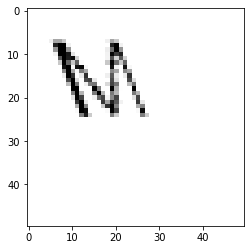

In [4]:
print(f"Letter {targets[0]}")
plt.imshow(inputs_[0], cmap='Greys')

#### 2. Data Transformation

Resulting output vector of 25 values between 0 and 1, higher values indicate a higher likelihood that the associated letter is the letter represented by the input.

In [5]:
inputs_ = np.array(inputs_, dtype='float')

# One hot encoding
onehot = OneHotEncoder()
out_put = onehot.fit_transform(np.array(targets).reshape(len(targets), 1))
out_put = np.array(out_put.todense())

While only 90% of the letter images provided will be used to train the convolutional neural network in order to create prediction models of letters, the other 10% will be reserved for further exploration and plunge into model performance analysis. Training data consists of generated image letters with each image character being labeled at the letter position alphabetically.

In [6]:
# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(inputs_, out_put, train_size=0.9)

#### 3. Convolutional Neural Network
Convolutional Neural Networks works best with unstructured data such as images, text, audio and speech. It do a good job whenever there is a topology associated with the data. It's inspired by multi-layer Perceptrons, it impose local connectivity constraints between neurons of adjacent layers. It process data through the convolution operation.

Through the training of the CNN the algorithm,

   - Learns Image-Processing filters
   - Detects patterns & make sense of them


#### 3.a Chosen Structure

Convolutional neural networks receive a letter image of *(50x50)* and produce a prediction vector of value 25, where the index of the highest value is the index of the letter in alphabetical order. The proposed CNN is a stack of layers that contains two Convolutional layers having filters of size *(32x32)* and a kernel size of *5x5*,followed by a maxpooling layer of size *(2x2)*, and a drop value of 0.25. AdamOptimizer is used to estimate CNN parameters, and minimize the loss function in this case "Categorical Cross Entropy".

- Does higher values of strides will accelerate the training phase ? (Because we are moving faster arround pixels)

In [214]:
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import TensorBoard
import time

In [211]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (50, 50, 1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 50, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 50, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(25, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
    )
    return model

In [223]:
tensorboard = TensorBoard(log_dir=f"logs/{time.time()}", histogram_freq=1)

model = build_model()

history = model.fit(
    X_train,
    y_train,
    epochs=6,
    batch_size=32,
    validation_data=(
        X_test,
        y_test
    )
)

Train on 2700 samples, validate on 300 samples
Epoch 1/6
2700/2700 [==============================] - 12s 4ms/sample - loss: 1.1664 - acc: 0.6563 - val_loss: 0.0232 - val_acc: 0.9967
Epoch 2/6
2700/2700 [==============================] - 13s 5ms/sample - loss: 0.0729 - acc: 0.9859 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 3/6
2700/2700 [==============================] - 13s 5ms/sample - loss: 0.0082 - acc: 0.9974 - val_loss: 2.0275e-04 - val_acc: 1.0000
Epoch 4/6
2700/2700 [==============================] - 13s 5ms/sample - loss: 0.0088 - acc: 0.9967 - val_loss: 6.1361e-05 - val_acc: 1.0000
Epoch 5/6
2700/2700 [==============================] - 13s 5ms/sample - loss: 0.0031 - acc: 0.9985 - val_loss: 4.6455e-06 - val_acc: 1.0000
Epoch 6/6
2700/2700 [==============================] - 13s 5ms/sample - loss: 9.8427e-05 - acc: 1.0000 - val_loss: 2.2137e-06 - val_acc: 1.0000


In [224]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 50, 50, 32)        832       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 32)        25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 25, 50)        14450     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 50)        22550     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 50)       

__Save Model__


In [225]:
model_json = model.to_json()

with open("captchas_model_num01.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("captchas_model_num01.h5")

In [226]:
predictions = model.predict(X_test)

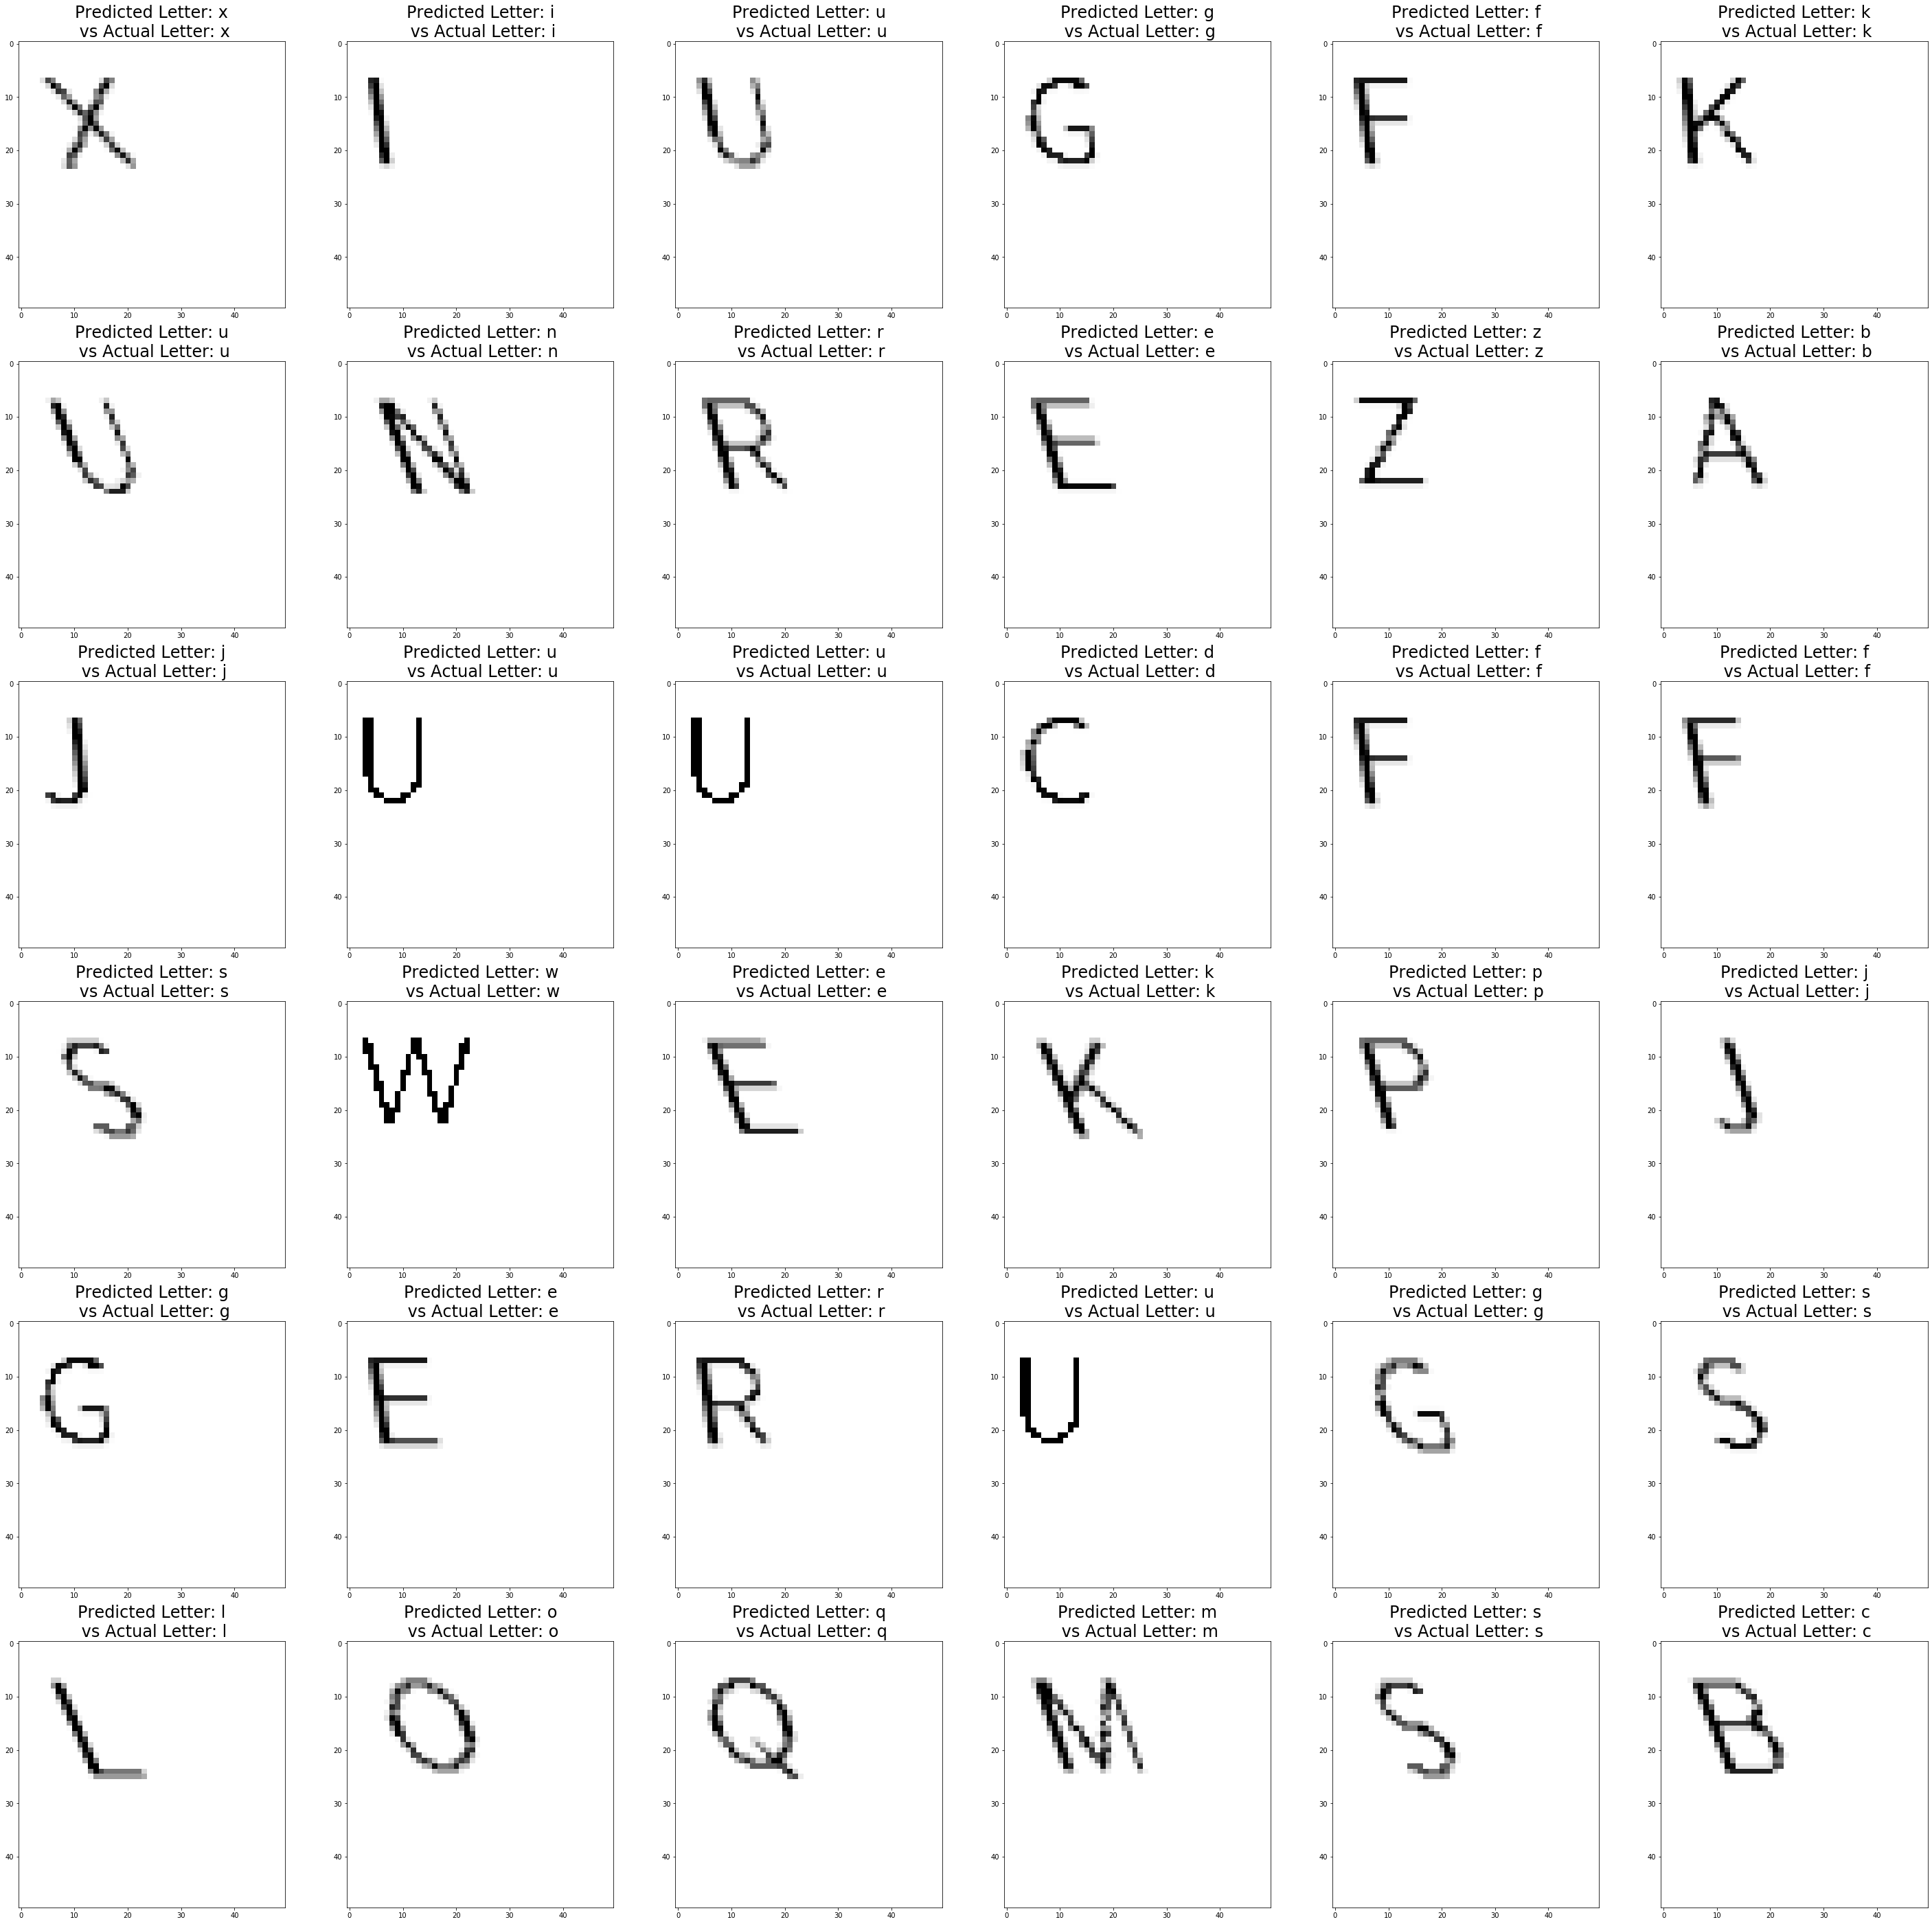

In [227]:
import random
import string

letters = list(string.ascii_lowercase)
ROWS = 6
COLUMNS = 6
fig, ax = plt.subplots(ROWS,COLUMNS, figsize=(50,50))

for row in range(ROWS):
    for column in range(COLUMNS):
        imgIndex = random.randint(0, len(X_test))
        image = X_test[imgIndex]
        image = image.reshape(50,50)
        ax[row,column].imshow(image,cmap='Greys')
        ax[row, column].set_title(f"Predicted Letter: {letters[np.argmax(predictions[imgIndex])+1]}\n vs Actual Letter: {letters[np.argmax(y_test[imgIndex])+1]}", fontSize=24)

### B. Predict Words in the CAPTCHAS
Splitting image into indiviual letters. Breaking the problem down into a smaller problem: predicting letters.
- Segmenting the word to discover each of the letter withing it
    - Find contiguous sections of black pixel on the image
    - Extract them as sub-images

#### 1. Loading CAPTCHAS Images & Labels

In [135]:
with open("../../data/captchas/words-base-captchas/words-basic-img", "rb") as f:
    words_inputs = pickle.load(f)
    
with open("../../data/captchas/words-base-captchas/words-label", "rb") as f:
    words_labels = pickle.load(f)


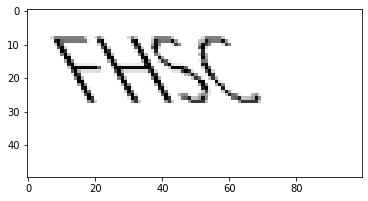

In [147]:
CaptchasGenerator().display_word(words_inputs[0])

#### 2. CAPTCHAS Segmentation
- Extract letters from actual CAPTCHAS
- Label extracted letters

By finding connected sets of pixels that have same value label takes image and return an array of the same shape as the original. To understand more how skimage will split words image into letters, : 

- __Label__ connected regions of an integer array. 
    Two pixels are connected when they are neighbors and have the same value. In 2D, they can be neighbors either in a 1- or 2-connected sense. The value refers to the maximum number of orthogonal hops to consider a pixel/voxel a neighbor.
    
- __Regionprop__ measure properties of labeled image regions.

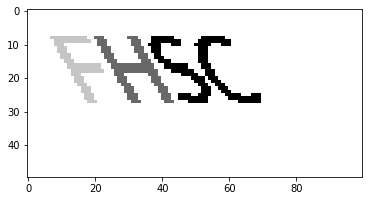

In [232]:
# Word Skimage label
CaptchasGenerator().display_word(label(words_inputs[0]> 0))

In [148]:
# Segmentation
from skimage.measure import label, regionprops
def segment_image(image):
    """ Return list of sub-images letters from the original word image """
    
    # Detect where each letter is 
    labeled_image = label(image > 0)
    
    subimages = []
    
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

#### 2.a Display Words Segmentation

In [143]:
def display_subimages(subimages, figsize=(10,4), cmap = 'gray'):
    f, axes = plt.subplots(1,len(subimages), figsize=figsize)
    for i in range(len(subimages)):
          axes[i].imshow(subimages[i], cmap=cmap)
    return f, axes


(<Figure size 720x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f72d66669d0>,
       dtype=object))

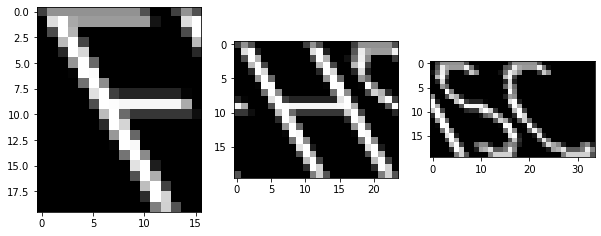

In [190]:
display_subimages(segment_image(words_inputs[0]))

#### 3. Predicting Words

In [242]:
def predict_captchas(captcha_images, model):
    
    for captcha_image in captcha_images:
        subimages = segment_image(captcha_image)

        predicted_word = ""
        letters = string.ascii_uppercase
        for subimage in subimages:
            subimage = resize(np.array(subimage),(50,50)).reshape(-1,50,50,1)
            let_prediction = letters[np.argmax(model.predict(subimage))]

            predicted_word += let_prediction

        yield predicted_word,captcha_image


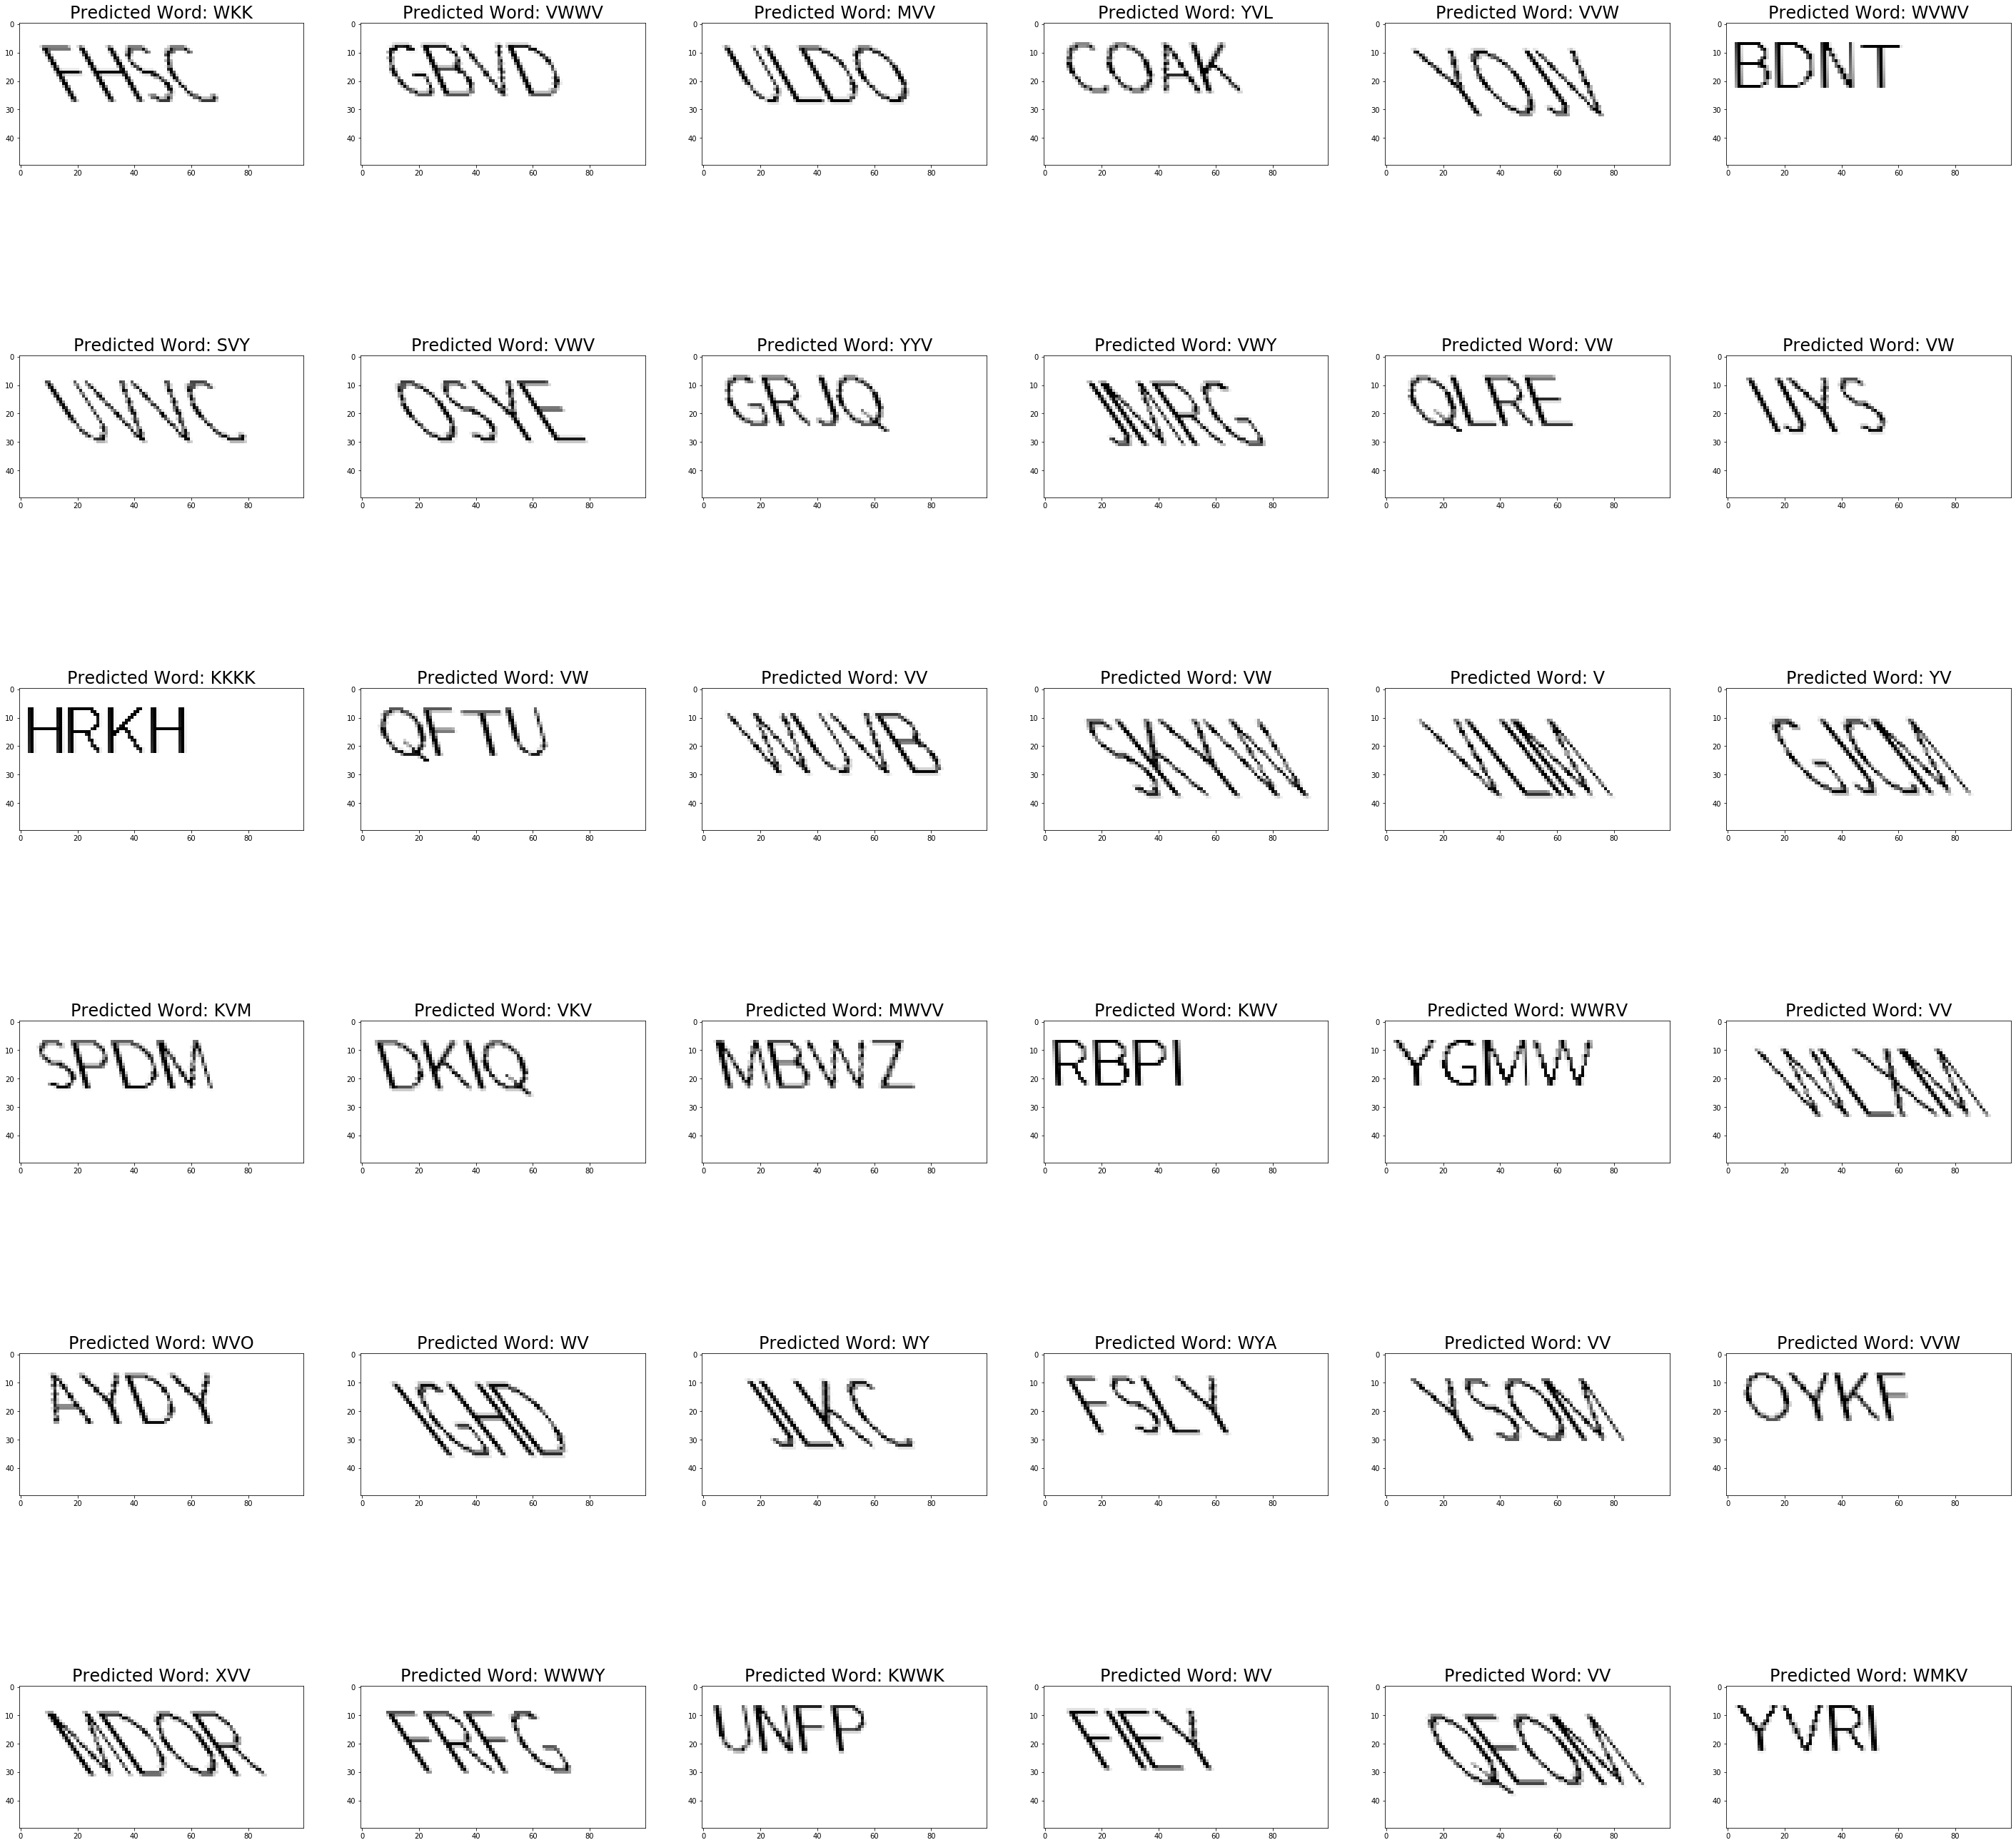

In [243]:
prediction = predict_captchas(words_inputs, model)
ROWS = 6
COLUMNS = 6
fig, ax = plt.subplots(ROWS,COLUMNS, figsize=(50,50))

for row in range(ROWS):
    for column in range(COLUMNS):
        predicted_word, captcha_image = next(prediction)
        ax[row,column].imshow(captcha_image,cmap='Greys')
        ax[row, column].set_title(f"Predicted Word: {predicted_word}", fontSize=24)

#### 3.a Predicting Words Accuracy

In [250]:
num_captch = len(words_inputs)
prediction = predict_captchas(words_inputs, model)

statistics = {'PREDICT_WORDS_LENGTH':[]}
i=0
while i<=num_captch:
        try:
            predicted_word, captcha_image = next(prediction)
        except StopIteration:
            print("FINISHED CAPTCHAS Battle")
            break
        if predicted_word == words_labels[i]:
            statistics['MATCHED_PREDICTION'] += 1
        statistics['PREDICT_WORDS_LENGTH'].append(len(predicted_word))
        i+=1

StopIteration: 

# Conclusion